Use Pytorch and monai(to load pretrained 3D Unet model) library instead of keras and segmentation models.

# Import

In [1]:
import json
import random
import tifffile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
from torchmetrics import Dice
from monai.losses import DiceFocalLoss
from monai.networks.nets import Unet

# Config

In [2]:
LOG_DIR = "./006_logs"
ROOT_PATH = "./data_3d/sandstone_data_for_ML/data_for_3D_Unet"
DATA_PATH = ROOT_PATH + "/train_images_256_256_256.tif"
TARGET_PATH = ROOT_PATH + "/train_masks_256_256_256.tif"

SEED = 42
TEST_SIZE = 0.25
BATCH_SIZE = 8
NUM_WORKERS = 2
LR = 1e-3
EPOCHS = 50
EARLY_STOP = True
PATIENCE = 3

nb_classes = 4
device = "cuda" if torch.cuda.is_available() else "cpu"

---

# Dataset

In [3]:
class StoneDataset(torch.utils.data.Dataset):
    def __init__(self,
                 data_path,
                 target_path,
                 test_size,
                 train=False,
                 seed=42):
        self.data_path = data_path
        self.target_path = target_path
        self.test_size = test_size
        self.seed = seed
        train_, test_ = self.__create_dataset()
        if train == True:
            self.data = train_
        else:
            self.data = test_

    def __len__(self):
        return len(self.data[0])
    
    def __getitem__(self, idx):
        image = self.data[0][idx].astype(np.float32) / 255
        mask = self.data[1][idx]
        return image, mask

    def __create_dataset(self):
        images = tifffile.imread(self.data_path)
        masks = tifffile.imread(self.target_path)

        # Split to small 3D patches
        img_patches = patchify(images, (64, 64, 64), step=64)
        mask_pataches = patchify(masks, (64, 64, 64), step=64)

        input_img = img_patches.reshape((-1, 1, *img_patches.shape[3:]))
        input_mask = mask_pataches.reshape((-1, 1, *mask_pataches.shape[3:]))

        img_train, img_test, mask_train, mask_test = train_test_split(
            input_img, input_mask, test_size=self.test_size,
            random_state=self.seed)
        
        return (img_train, mask_train), (img_test, mask_test)

In [4]:
train_dataset = StoneDataset(data_path=DATA_PATH,
                             target_path=TARGET_PATH,
                             test_size=TEST_SIZE,
                             seed=SEED,
                             train=True)
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS,
                          pin_memory=True)

valid_dataset = StoneDataset(data_path=DATA_PATH,
                             target_path=TARGET_PATH,
                             test_size=TEST_SIZE,
                             seed=SEED,
                             train=False)
valid_loader = DataLoader(valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=NUM_WORKERS,
                          pin_memory=True)

# Model, Loss function, Metric, Optimizer

In [5]:
model_config = {
    "spatial_dims": 3, # Use 3D model
    "in_channels": 1,
    "out_channels": 4,
    "channels": (16, 32, 64, 128, 256),
    "strides": (2, 2, 2, 2)
}

model = Unet(
    **model_config
).to(device)

criterion = DiceFocalLoss(include_background=True,
                          to_onehot_y=True,
                          softmax=True)
metric = Dice(num_classes=nb_classes)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LR)

# Training

In [6]:
tk0 = tqdm(range(EPOCHS), total=EPOCHS)
train_losses = []
train_dices = []
valid_losses = []
valid_dices = []


for epoch in tk0:

    train_loss, train_dice = 0, 0
    model.train()
    for data, mask in train_loader:
        data, mask = data.to(device), mask.to(device)
        out = model(data)

        loss = criterion(out, mask)
        dice = metric(out, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += dice.item()

    train_loss /= len(train_loader)
    train_dice /= len(train_loader)

    train_losses.append(train_loss)
    train_dices.append(train_dice)
    
    valid_loss, valid_dice = 0, 0
    model.eval()
    with torch.inference_mode():
        for data, mask in valid_loader:
            data, mask = data.to(device), mask.to(device)
            out = model(data)

            loss = criterion(out, mask)
            dice = metric(out, mask)

            valid_loss += loss.item()
            valid_dice += dice.item()

    valid_loss /= len(valid_loader)
    valid_dice /= len(valid_loader)

    valid_losses.append(valid_loss)
    valid_dices.append(valid_dice)

    tk0.set_postfix(train_loss=f"{train_losses[-1]:.4g}",
                    train_dice=f"{train_dices[-1]:.4g}",
                    valid_loss=f"{valid_losses[-1]:.4g}",
                    valid_dice=f"{valid_dices[-1]:.4g}",)

100%|██████████| 50/50 [04:52<00:00,  5.85s/it, train_dice=0.9728, train_loss=0.2293, valid_dice=0.8926, valid_loss=0.5293]


In [7]:
torch.save(model.state_dict(),
           LOG_DIR + "/Monai_Unet_3D.pth")

with open(LOG_DIR + "/model_config.json", "w") as f:
    json.dump(model_config, f)

results = pd.DataFrame(
    {
        "epoch": range(EPOCHS),
        "train_loss": train_losses,
        "train_dice": train_dices,
        "valid_loss": valid_losses,
        "valid_dice": valid_dices,
    }
)
results.to_csv(LOG_DIR + "/results.csv", index=False)

# Train result

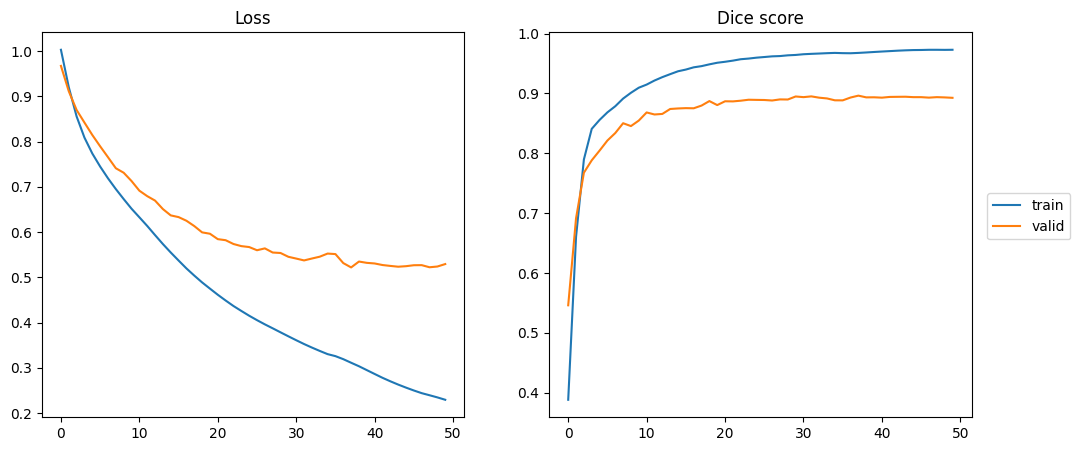

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(train_losses)
axes[0].plot(valid_losses)
axes[0].set_title("Loss")

axes[1].plot(train_dices, label="train")
axes[1].plot(valid_dices, label="valid")
axes[1].set_title("Dice score")

plt.legend(bbox_to_anchor=(1.25, 0.6))
plt.show()

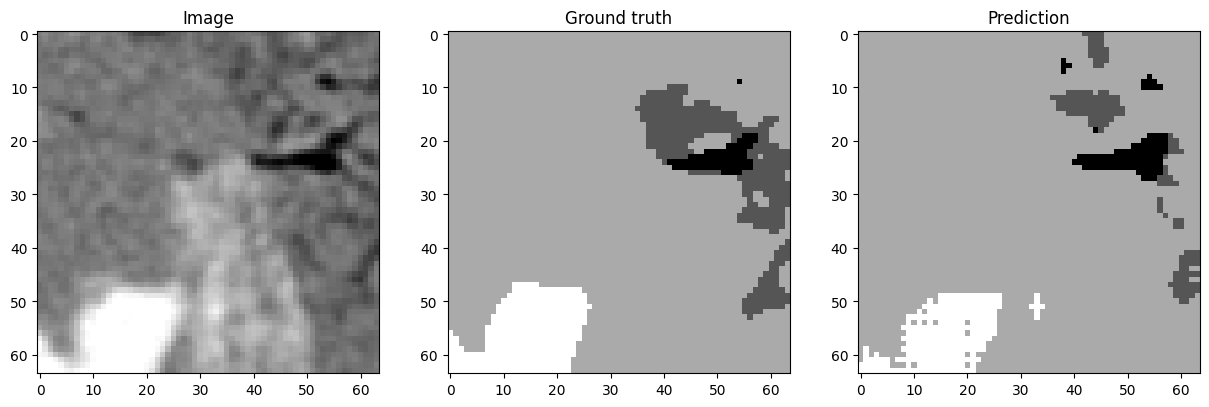

In [9]:
img_idx = 2
slice_idx = 60
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(data[img_idx][0][slice_idx].cpu().numpy(), cmap='gray')
axes[0].set_title("Image")
axes[1].imshow(mask[img_idx][0][slice_idx].cpu().numpy(), cmap='gray')
axes[1].set_title("Ground truth")
axes[2].imshow(torch.argmax(out[img_idx], dim=0)[slice_idx].cpu().numpy(),
               cmap='gray')
axes[2].set_title("Prediction")
plt.show()

# Inference

In [10]:
TEST_FILE = "448_images_512x512.tif"
test_tif = tifffile.imread(ROOT_PATH + "/" + TEST_FILE)

In [11]:
with open(LOG_DIR + "/model_config.json") as f:
    model_config = json.load(f)
model = Unet(**model_config)
model.load_state_dict(
    torch.load(
        LOG_DIR + "/Monai_Unet_3D.pth",
        map_location=device
        )
)

<All keys matched successfully>

In [12]:
test_patches = patchify(test_tif, (64, 64, 64), step=64)

pred_patches = []
model.eval()
with torch.inference_mode():
    for i in range(test_patches.shape[0]):
        for j in range(test_patches.shape[1]):
            for k in range(test_patches.shape[2]):
                single_patch = test_patches[i, j, k, ...]
                single_patch = torch.tensor(single_patch) / 255
                single_patch = single_patch.unsqueeze(0).unsqueeze(0)
                single_proba = model(single_patch)
                single_pred = torch.argmax(single_proba, dim=1)
                
                pred_patches.append(single_pred.cpu())

pred_patches = np.stack(pred_patches).squeeze()
pred_patches_reshaped = pred_patches.reshape(test_patches.shape)

reconstructed_image = unpatchify(pred_patches_reshaped, test_tif.shape)
reconstructed_image = reconstructed_image.astype(np.uint8)

In [13]:
tifffile.imwrite(LOG_DIR + "/pred_" + TEST_FILE,
                 reconstructed_image)

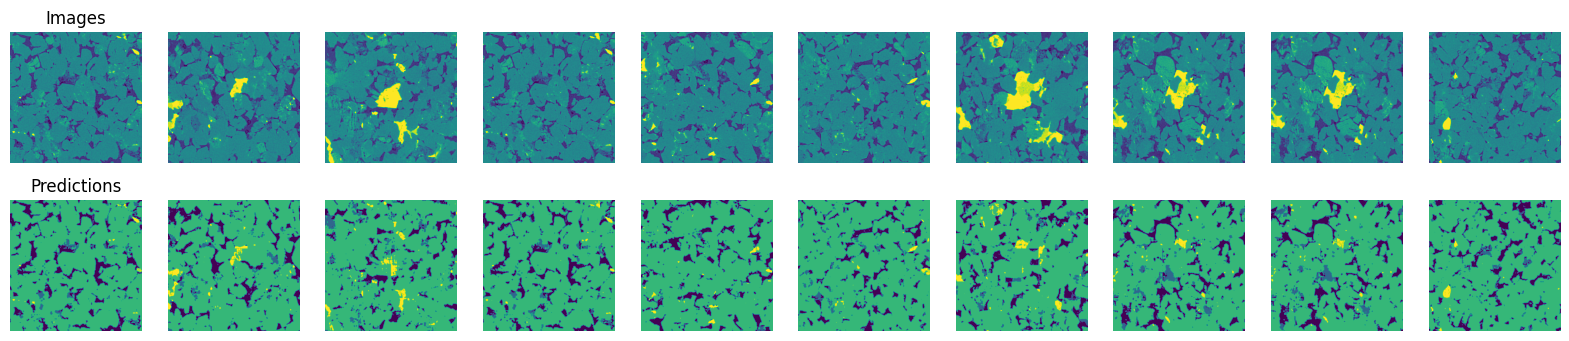

In [16]:
fig, axes = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    idx = random.randint(0, test_tif.shape[0])
    axes[0, i].imshow(test_tif[idx])
    axes[1, i].imshow(reconstructed_image[idx])
    axes[0, i].axis("off")
    axes[1, i].axis("off")
axes[0, 0].set_title("Images")
axes[1, 0].set_title("Predictions")
plt.show()

The labels are also unbalanced in the test image. Therefore, the model did not predict well on certain labels, especially the yellow label in the original test image. Other areas seem to be doing well.